In [1]:
##Estimación de indicadores de gobierno
#Se borra todo lo que se encuentra en el entorno

#rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, srvyr,showtext)
remotes::install_github("cpyp-ipdp/funcionespgd", force = TRUE)
library(funcionespgd)

Cargando paquete requerido: pacman

Using GitHub PAT from the git credential store.




rlang  (1.1.4 -> 1.1.6) [CRAN]
glue   (1.7.0 -> 1.8.0) [CRAN]
cli    (3.6.3 -> 3.6.5) [CRAN]
tibble (3.2.1 -> 3.3.0) [CRAN]


Installing 4 packages: rlang, glue, cli, tibble

Warning message:
"package 'tibble' is in use and will not be installed"
Installing packages into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'rlang' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rlang'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\rlang\libs\x64\rlang.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\rlang\libs\x64\rlang.dll: Permission denied"
Warning message:
"restored 'rlang'"


package 'glue' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'glue'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\glue\libs\x64\glue.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\glue\libs\x64\glue.dll: Permission denied"
Warning message:
"restored 'glue'"


package 'cli' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'cli'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\cli\libs\x64\cli.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\cli\libs\x64\cli.dll: Permission denied"
Warning message:
"restored 'cli'"



The downloaded binary packages are in
	C:\Users\claud\AppData\Local\Temp\Rtmp8WsQMW\downloaded_packages
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file 'C:\Users\claud\AppData\Local\Temp\Rtmp8WsQMW\remotes57346970f20\cpyp-ipdp-funcionespgd-3fffa52/DESCRIPTION' ... OK
* preparing 'funcionespgd':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted 'LazyData' from DESCRIPTION
* building 'funcionespgd_0.1.0.tar.gz'



Installing package into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



In [2]:
font_add_google("Poppins", "pop")
showtext_auto()

In [3]:
dir.create("data", showWarnings = FALSE)

In [4]:
url_encig_basica<-"https://www.inegi.org.mx/contenidos/programas/encig/"
segunda_parte<-"microdatos/encig"
years_encig<-c("2017","2019","2021", "2023")

In [5]:
# Descargar los archivos, descomprimirlos y renombrarlos
options(timeout=10000)
for (i in 1:length(years_encig)) {
  # Ajustar el sufijo de la URL y archivo según el año
  if (years_encig[i] %in% c("2017", "2019")) {
    fin <- "_base_datos_dbf.zip"
  } else {
    fin <- "_base_datos_csv.zip"
  }

  # Construir la URL y el nombre del archivo destino
  url <- paste0(url_encig_basica, years_encig[i], "/", segunda_parte, str_sub(years_encig[i], 3, 4), fin)
  print(url)
  destfile <- paste0("data/encig", str_sub(years_encig[i], 3, 4), fin)

  # Descargar el archivo
  download.file(url, destfile = destfile)

  # Descomprimir el archivo
  unzip(destfile, exdir = "data")
}

[1] "https://www.inegi.org.mx/contenidos/programas/encig/2017/microdatos/encig17_base_datos_dbf.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/encig/2019/microdatos/encig19_base_datos_dbf.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/encig/2021/microdatos/encig21_base_datos_csv.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/encig/2023/microdatos/encig23_base_datos_csv.zip"


In [6]:
# Función de estimación
process_files <- function(years, variable) {
  # Función anidada para estimar el indicador
  estima_indicador <- function(path, variable) {
    # Extraer el año del archivo
    year <- substr(path, 11, 14)

    # Leer los datos y hacer las transformaciones necesarias de las variables
    if (year %in% c("2017", "2019")) {
      datos <- foreign::read.dbf(path) %>%
        janitor::clean_names() %>%
        mutate(p11_1_6 = if ("p11_1_6" %in% names(.)) as.numeric(p11_1_6) else as.numeric(p3_2),
               fac_p18 = as.numeric(fac_p18),
               upm = as.numeric(upm),
               est_dis = as.numeric(est_dis)) %>%
        # Filtrar Ciudad de México
        filter(ent == "09")
    } else if (year %in% c("2021", "2023")) {
      datos <- read_csv(path, show_col_types = FALSE) %>%
        janitor::clean_names() %>%
        rename_with(~ ifelse(. == "p11_1_06", "p11_1_6", .)) %>%
        # Filtrar Ciudad de México
        filter(nom_ent == "CIUDAD DE MEXICO")
    } else {
      stop("Año no soportado.")
    }

    # Diseño muestral
    dm <- datos %>%
      as_survey_design(ids = upm, strata = est_dis, weights = fac_p18)

    # Confianza
    if (variable == "confianza") {
      confianza_gob <- dm %>%
        mutate(confianza = case_when(
          p11_1_6 == 1 | p11_1_6 == 2 ~ "Confía",
          TRUE ~ "No confía"
        )) %>%
        group_by(confianza) %>%
        summarise(
          personas = survey_total(vartype = "cv"),
          porcentaje = survey_mean(vartype = "cv")
        ) %>%
        # Filtrar confianza
        filter(confianza == "Confía") %>%
        mutate(porcentaje = round(porcentaje * 100, 2),
               year = year)
      return(confianza_gob)

      # Actos de corrupción
    } else if (variable == "actos_corrupcion") {
      actos_corrup <- dm %>%
        mutate(actos_corrupcion = case_when(
          p3_2 == 1 | p3_2 == 2 ~ "Frecuentes",
          TRUE ~ "No frecuentes"
        )) %>%
        group_by(actos_corrupcion) %>%
        summarise(
          personas = survey_total(vartype = "cv"),
          porcentaje = survey_mean(vartype = "cv")
        ) %>%
        filter(actos_corrupcion == "Frecuentes") %>%
        mutate(porcentaje = round(porcentaje * 100, 2),
               year = year)
      return(actos_corrup)

    } else {
      stop("Variable no reconocida.")
    }
  }

  map_dfr(years, function(year) {
    # Seleccionar el archivo correcto según la variable y el año
    file_path <- if (variable == "actos_corrupcion") {
      if (year %in% c(2017, 2019)) {
        paste0("data/encig", year, "_01_sec1_3_4_5_8_9_10.dbf")
      } else if (year %in% c(2021, 2023)) {
        paste0("data/encig", year, "_01_sec1_A_3_4_5_8_9_10.csv")
      } else {
        stop("Año no soportado para actos de corrupción.")
      }
    } else if (variable == "confianza") {
      if (year %in% c(2017, 2019)) {
        paste0("data/encig", year, "_01_sec_11.dbf")
      } else if (year %in% c(2021, 2023)) {
        paste0("data/encig", year, "_01_sec_11.csv")
      } else {
        stop("Año no soportado para confianza.")
      }
    } else {
      stop("Variable no reconocida.")
    }

    # Print del archivo que se está procesando
    print(paste("Procesando archivo:", file_path))

    # Invocar la función de estimación
    estima_indicador(file_path, variable)
  })
}


In [7]:
# Estimar indicadores de gobierno
tabla_confianza<-process_files(years_encig, variable = "confianza")
print("Porcentaje de personas que confían en el gobierno de la Ciudad de México")
tabla_confianza

[1] "Procesando archivo: data/encig2017_01_sec_11.dbf"
[1] "Procesando archivo: data/encig2019_01_sec_11.dbf"
[1] "Procesando archivo: data/encig2021_01_sec_11.csv"


New names:
• `` -> `...1`


[1] "Procesando archivo: data/encig2023_01_sec_11.csv"


New names:
• `` -> `...1`


[1] "Porcentaje de personas que confían en el gobierno de la Ciudad de México"


confianza,personas,personas_cv,porcentaje,porcentaje_cv,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Confía,1241859,0.05099752,14.16,0.04852940,2017
Confía,2836364,0.02448298,40.87,0.02166087,2019
Confía,3351823,0.02201146,48.17,0.01892866,2021
Confía,3446410,0.02412965,45.49,0.01937280,2023


In [8]:
tabla_actos_corrupcion<-process_files(years_encig, variable = "actos_corrupcion")
print("Porcentaje de personas que perciben actos de corrupción en la Ciudad de México")
tabla_actos_corrupcion

[1] "Procesando archivo: data/encig2017_01_sec1_3_4_5_8_9_10.dbf"
[1] "Procesando archivo: data/encig2019_01_sec1_3_4_5_8_9_10.dbf"
[1] "Procesando archivo: data/encig2021_01_sec1_A_3_4_5_8_9_10.csv"


New names:
• `` -> `...1`


[1] "Procesando archivo: data/encig2023_01_sec1_A_3_4_5_8_9_10.csv"


New names:
• `` -> `...1`


[1] "Porcentaje de personas que perciben actos de corrupción en la Ciudad de México"


actos_corrupcion,personas,personas_cv,porcentaje,porcentaje_cv,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Frecuentes,8410975,0.01634467,95.94,0.003774120,2017
Frecuentes,6247296,0.01193104,90.02,0.005535388,2019
Frecuentes,6248752,0.01368776,89.81,0.005471011,2021
Frecuentes,6648218,0.01374265,87.76,0.006548517,2023


### Proyecciones

In [9]:
tabla_confianza%>%
filter(year>2017)

confianza,personas,personas_cv,porcentaje,porcentaje_cv,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Confía,2836364,0.02448298,40.87,0.02166087,2019
Confía,3351823,0.02201146,48.17,0.01892866,2021
Confía,3446410,0.02412965,45.49,0.01937280,2023


In [10]:
tcma_confianza<-((tabla_confianza$porcentaje[tabla_confianza$year==2021]/tabla_confianza$porcentaje[tabla_confianza$year==2019])^(1/(2021-2019))-1)
tcma_confianza

[1] 0.08564042

In [11]:
# Número de años en cada periodo
años_original <- 2021 - 2019
años_nuevo <- 2045 - 2024

# Factor de ajuste
factor_ajuste <- (años_nuevo / años_original)
tasa_crecimiento_ajustada <- tcma_confianza / factor_ajuste
tasa_crecimiento_ajustada

[1] 0.00815623

In [12]:
extendido_confianza<-data.frame(year=2024:2045)

extendido_confianza$porcentaje<-tabla_confianza$porcentaje[tabla_confianza$year==2023]*cumprod(rep(1+tasa_crecimiento_ajustada,length(2024:2045)))
extendido_confianza%>%
mutate(porcentaje=round(porcentaje,2))

year,porcentaje
<int>,<dbl>
2024,45.86
2025,46.24
2026,46.61
2027,46.99
2028,47.38
2029,47.76
2030,48.15
2031,48.54
2032,48.94


In [13]:
tab_graph_confianza<-tabla_confianza%>%
mutate(year=as.integer(year))%>%
select(year,porcentaje)%>%
#Pegar con la tabla extendida
bind_rows(extendido_confianza)%>%
filter(year>2017)
#tab_graph_confianza

Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'rob' not found, w

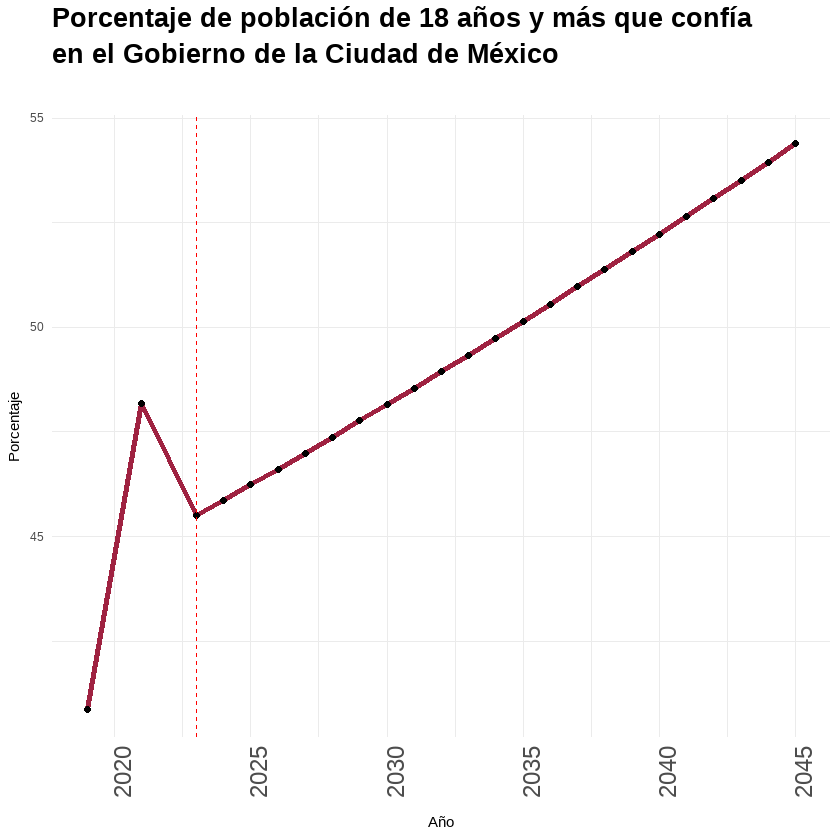

In [14]:
tab_graph_confianza%>%
ggplot(aes(x=year,y=porcentaje))+geom_line(color="#9f2241",linewidth=1.5)+geom_point()+
geom_vline(xintercept = c(2023), linetype = "dashed", color = "red")+

theme_minimal()+
labs(title="Porcentaje de población de 18 años y más que confía
en el Gobierno de la Ciudad de México
",
x="Año",y="Porcentaje")+
    theme(
      plot.title = element_text(hjust = 0, size=20, face="bold"),
      plot.subtitle = element_text(hjust = 0, size=15, face="italic"),
      plot.caption = element_text(hjust = 0, size=10),
      legend.position = "None",
      legend.text = element_text(size=18),
      axis.text.x = element_text(angle = 90, hjust = 1, size=18),
      legend.title = element_text(size=18),
      text = element_text(family="rob")
    )

 ggsave("confianza_gob.png", width = 10, height = 6, dpi = 100,bg="white")

In [15]:
tabla_actos_corrupcion%>%
filter(year>2017)

actos_corrupcion,personas,personas_cv,porcentaje,porcentaje_cv,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Frecuentes,6247296,0.01193104,90.02,0.005535388,2019
Frecuentes,6248752,0.01368776,89.81,0.005471011,2021
Frecuentes,6648218,0.01374265,87.76,0.006548517,2023


In [16]:
str(tabla_actos_corrupcion)

tibble [4 × 6] (S3: tbl_df/tbl/data.frame)
 $ actos_corrupcion: chr [1:4] "Frecuentes" "Frecuentes" "Frecuentes" "Frecuentes"
 $ personas        : num [1:4] 8410975 6247296 6248752 6648218
 $ personas_cv     : num [1:4] 0.0163 0.0119 0.0137 0.0137
 $ porcentaje      : num [1:4] 95.9 90 89.8 87.8
 $ porcentaje_cv   : num [1:4] 0.00377 0.00554 0.00547 0.00655
 $ year            : chr [1:4] "2017" "2019" "2021" "2023"


In [17]:
tcma_actos_corrupcion<-((tabla_actos_corrupcion$porcentaje[tabla_actos_corrupcion$year==2023]/tabla_actos_corrupcion$porcentaje[tabla_actos_corrupcion$year==2019])^(1/(2023-2019))-1)
tcma_actos_corrupcion

[1] -0.006336353

In [18]:
# Número de años en cada periodo
años_original <- 2023 - 2019
años_nuevo <- 2045 - 2024

# Factor de ajuste
factor_ajuste_corrup <- (años_nuevo / años_original)
tasa_crecimiento_ajustada_c <- tcma_actos_corrupcion/ factor_ajuste_corrup
tasa_crecimiento_ajustada_c

[1] -0.001206924

In [19]:
extendido_corrupcion<-data.frame(year=2024:2045)

extendido_corrupcion$porcentaje<-tabla_actos_corrupcion$porcentaje[tabla_actos_corrupcion$year==2023]*cumprod(rep(1+tcma_actos_corrupcion,length(2024:2045)))
extendido_corrupcion%>%
mutate(porcentaje=round(porcentaje,2),
         year=as.integer(year))


year,porcentaje
<int>,<dbl>
2024,87.20
2025,86.65
2026,86.10
2027,85.56
2028,85.01
2029,84.48
2030,83.94
2031,83.41
2032,82.88


In [20]:
tab_graph_corrup<-tabla_actos_corrupcion%>%
mutate(year=as.integer(year))%>%
select(year,porcentaje)%>%
#Pegar con la tabla extendida
bind_rows(extendido_corrupcion)
#tab_graph_corrup

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'rob' not found, will use 'sans' instead"
Warning message in grid.Call(C_textBounds

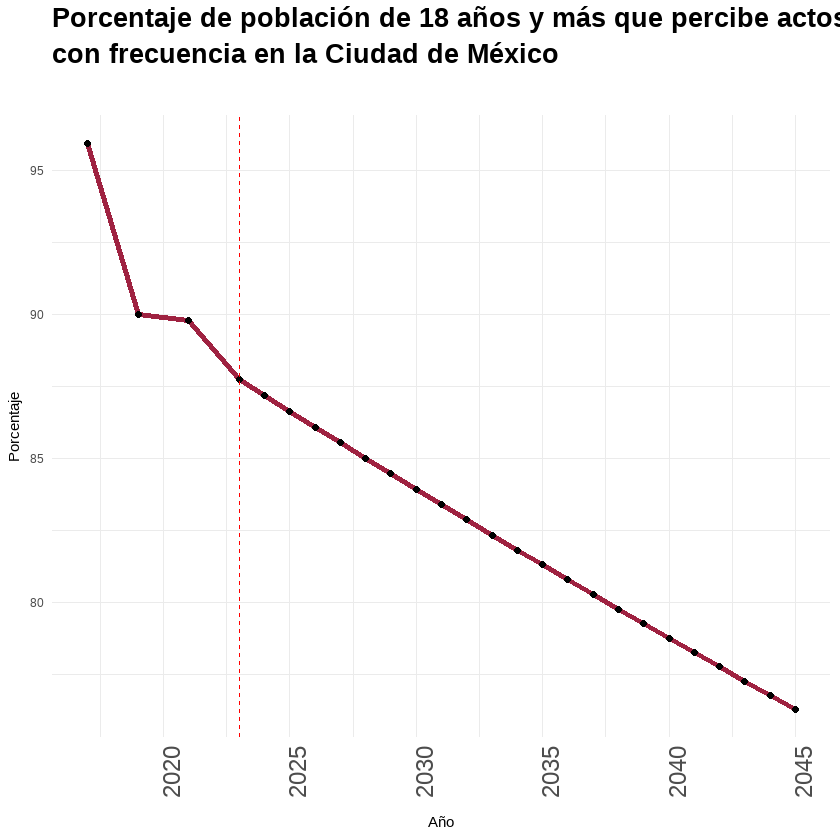

In [21]:
tab_graph_corrup%>%
ggplot(aes(x=year,y=porcentaje))+geom_line(color="#9f2241",linewidth=1.5)+geom_point()+
geom_vline(xintercept = c(2023), linetype = "dashed", color = "red")+

theme_minimal()+
labs(title="Porcentaje de población de 18 años y más que percibe actos de corrupción
con frecuencia en la Ciudad de México
",
x="Año",y="Porcentaje")+
    theme(
      plot.title = element_text(hjust = 0, size=20, face="bold"),
      plot.subtitle = element_text(hjust = 0, size=15, face="italic"),
      plot.caption = element_text(hjust = 0, size=10),
      legend.position = "None",
      legend.text = element_text(size=18),
      axis.text.x = element_text(angle = 90, hjust = 1, size=18),
      legend.title = element_text(size=18),
      text = element_text(family="rob")
    )

 ggsave("corrupcion_gob.png", width = 10, height = 6, dpi = 100,bg="white")

### Escenarios

In [22]:
generar_grafica <- function(tabla_obs, tabla_est, margen, titulo,base, linea_base,
                            nombre_archivo, nombre_estimado_futuro,despegue,
                            nombre_intervalo_superior, nombre_intervalo_inferior,
                            limite_inferior_y, variable_intervals = "porcentaje") {

  serie_completa <- dplyr::bind_rows(
    tabla_obs %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(variable_intervals, margen = 0, año_base = base),

    tabla_est %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(variable_intervals, margen = margen, año_base = base)
  )

  grafica <- grafica_bonita(
    data = serie_completa,
    x = "year",
    y = "estimado",
    titulo = titulo,
   ano_base=base,
     mostrar_etiqueta_ano_base = TRUE,
     desplazamiento_ano_base = despegue,
    linea_vertical = linea_base,
    anios_etiquetas=c(2045),
    mostrar_intervalo = "ambos",
    nombre_observado = "Observado",
    nombre_estimado_futuro = nombre_estimado_futuro,
    nombre_intervalo_superior = nombre_intervalo_superior,
    nombre_intervalo_inferior = nombre_intervalo_inferior,
    mostrar_leyenda = TRUE,
    fuente = "pop",
    etiqueta_x = "Año",
    etiqueta_y = "Porcentaje",
    titulo_leyenda = "Escenarios",
    limite_inferior_y = limite_inferior_y
  )

  ggplot2::ggsave(paste0("H:/Mi unidad/pgd/graficas/",nombre_archivo), grafica, 
  width = 10, height = 6, dpi = 185, bg = "white")
}

In [23]:
configuraciones <- tibble::tibble(
  tabla_obs = list(tabla_actos_corrupcion,tabla_confianza),
  tabla_est = list(extendido_corrupcion, extendido_confianza),
  margen = c(0.001, 0.001),
  base = c(2023, 2023),
  nombre_archivo = c("corrupcion_gob_estimada.png",
                     "confianza_gob_estimada.png"),
  linea_base = c(2023, 2023),
   despegue = list(
    c(0.7, 1),  
    c(1, 1) 
  ),
  titulo = c(
             "Porcentaje de población de 18 años y más 
que percibe actos de corrupción con frecuencia 
en la Ciudad de México",
             "Porcentaje de población de 18 años y más 
que confía en el Gobierno de la Ciudad de México"),
  nombre_estimado_futuro = c("Deseable", "Deseable"),
  nombre_intervalo_superior = c("Inercial", "Transformador"),
  nombre_intervalo_inferior = c("Transformador", "Inercial"),
  limite_inferior_y = c(65,40),
  variable_intervals = c("porcentaje", "porcentaje")
)

In [24]:
pmap(
  configuraciones,
  function(tabla_obs, tabla_est, margen,
  nombre_archivo,base,linea_base,
           titulo, nombre_estimado_futuro,despegue,
           nombre_intervalo_superior, nombre_intervalo_inferior,
           limite_inferior_y, variable_intervals) {
    generar_grafica(
      tabla_obs = tabla_obs,
      tabla_est = tabla_est,
      base=base,
      linea_base=linea_base,
      despegue=despegue,
      margen = margen,
      titulo = titulo,
      nombre_archivo = nombre_archivo,
      nombre_estimado_futuro = nombre_estimado_futuro,
      nombre_intervalo_superior = nombre_intervalo_superior,
      nombre_intervalo_inferior = nombre_intervalo_inferior,
      limite_inferior_y = limite_inferior_y,
      variable_intervals = variable_intervals
    )
  }
)

Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."


[[1]]
[1] "H:/Mi unidad/pgd/graficas/corrupcion_gob_estimada.png"

[[2]]
[1] "H:/Mi unidad/pgd/graficas/confianza_gob_estimada.png"